In [1]:
import numpy as np
import pandas as pd
import itertools
import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

import env
import wrangle as w
import explore as e
import prepare as p
import evaluate as eva

import warnings
warnings.filterwarnings("ignore")

# 1
Select a dataset with a continuous target variable.
# 2
Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.
# 3
Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

# Wrangle

- Acquired data from zillow.csv

- Create dummy vars, handled in import function

- Split data, handled with split data function

- Scale data, handled with scaled data function

In [2]:
# Acquired data from zillow.csv
# Create dummy vars, handled in import function
df = w.wrangle_zillow()
df

csv file found and loaded


,taxvalue,bedrooms,bathrooms,sqft,built,fips,Orange,Ventura
4,296425.0,4.0,2.0,3633.0,2005.0,LA,0,0
6,847770.0,3.0,4.0,1620.0,2011.0,LA,0,0
7,646760.0,3.0,2.0,2077.0,1926.0,LA,0,0
11,5328.0,0.0,0.0,1200.0,1972.0,LA,0,0
14,6920.0,0.0,0.0,171.0,1973.0,LA,0,0
...,...,...,...,...,...,...,...,...
2152856,422400.0,4.0,4.0,4375.0,2015.0,LA,0,0
2152858,960756.0,4.0,3.0,2262.0,2015.0,Orange,1,0
2152859,536061.0,4.0,4.5,3127.0,2014.0,Orange,1,0
2152861,424353.0,3.0,2.5,1974.0,2015.0,Orange,1,0


In [3]:
# split into train validate and test
train, validate, test = p.split_data(df)
train.head()

,taxvalue,bedrooms,bathrooms,sqft,built,fips,Orange,Ventura
731916,148309.0,3.0,2.0,1488.0,1980.0,LA,0,0
1286889,199476.0,2.0,1.0,864.0,1947.0,LA,0,0
1105466,921624.0,4.0,3.0,2532.0,1987.0,LA,0,0
1535462,311969.0,2.0,1.0,1144.0,1951.0,LA,0,0
1948233,1155354.0,3.0,3.5,2840.0,2005.0,Orange,1,0


In [4]:
## scale data
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = p.scaled_df(train, validate, test)
X_train_scaled.head()

,bedrooms,bathrooms,sqft,built,Orange,Ventura
731916,0.1875,0.100,0.297459,0.832558,0.0,0.0
1286889,0.1250,0.050,0.172635,0.679070,0.0,0.0
1105466,0.2500,0.150,0.506301,0.865116,0.0,0.0
1535462,0.1250,0.050,0.228646,0.697674,0.0,0.0
1948233,0.1875,0.175,0.567914,0.948837,1.0,0.0


In [5]:
X_validate_scaled.shape

(418292, 6)

In [6]:
y_validate.shape

(418292,)

In [7]:
y_train.head()

731916      148309.0
1286889     199476.0
1105466     921624.0
1535462     311969.0
1948233    1155354.0
Name: taxvalue, dtype: float64

# Explore target, set baseline

In [8]:
baseline = round(y_train.mean(),2)
baseline

394704.71

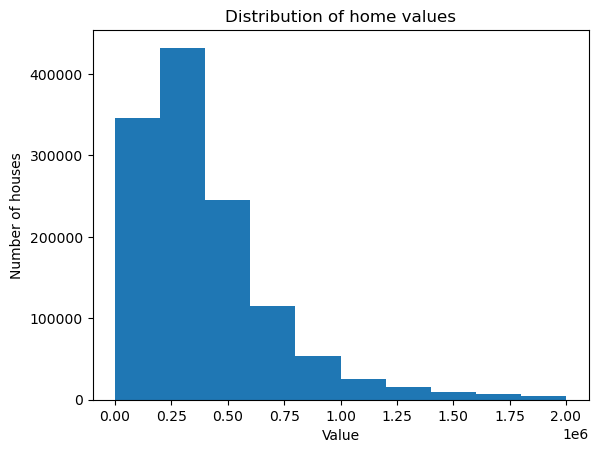

In [9]:
#visualize baseline
plt.hist(y_train)
plt.xlabel("Value")
plt.ylabel("Number of houses")
plt.title('Distribution of home values')
plt.show()

In [10]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array

array([394704.71, 394704.71, 394704.71, ..., 394704.71, 394704.71,
       394704.71])

In [11]:
# Evaluate the baseline rmse and r2
rmse, r2 = eva.metrics_reg(y_train, baseline_array)
rmse, r2

(307406.3577998372, 1.1102230246251565e-16)

In [12]:
# add results to a dataframe for comparison
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,307406.3578,1.110223e-16


# OLS - Ordinary Least Squares
- also using Recursive Feature Eliminations

In [162]:
#### make it
OLS = LinearRegression()
#use Recursive Feature Eliminations
rfe = RFE(OLS, n_features_to_select=6)
#fit it
rfe.fit(X_train_scaled, y_train)
#use it on train
X_train_rfe = rfe.transform(X_train_scaled)
#use it on validate
X_val_rfe = rfe.transform(X_validate_scaled)

In [163]:
X_train_rfe.shape

(1254875, 6)

In [164]:
X_val_rfe.shape

(418292, 6)

In [165]:
y_validate.shape

(418292,)

In [166]:
#see what the top features are regardless of location
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['bedrooms' 'bathrooms' 'sqft' 'built' 'Orange' 'Ventura']


In [167]:
#get array of rfe rankings and choose top minus location
rfe.ranking_

array([1, 1, 1, 1, 1, 1])

In [168]:
# see whats in the rfe
X_train_rfe

array([[0.1875    , 0.1       , 0.29745949, 0.83255814, 0.        ,
        0.        ],
       [0.125     , 0.05      , 0.17263453, 0.67906977, 0.        ,
        0.        ],
       [0.25      , 0.15      , 0.50630126, 0.86511628, 0.        ,
        0.        ],
       ...,
       [0.25      , 0.15      , 0.52190438, 0.84186047, 1.        ,
        0.        ],
       [0.1875    , 0.05      , 0.25265053, 0.65581395, 0.        ,
        0.        ],
       [0.25      , 0.15      , 0.68893779, 0.70697674, 0.        ,
        0.        ]])

In [169]:
#put results into a dataframe
pd.DataFrame(
{'rfe_ranking':rfe.ranking_},
index=X_train_scaled.columns)

,rfe_ranking
bedrooms,1
bathrooms,1
sqft,1
built,1
Orange,1
Ventura,1


In [170]:
# make a mask for the rfe
rfe.get_support()

array([ True,  True,  True,  True,  True,  True])

In [171]:
#apply the mask to the transformed data
X_train_RFEtransformed = pd.DataFrame(
    rfe.transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=X_train_scaled.columns[rfe.support_])
X_train_RFEtransformed.head()

,bedrooms,bathrooms,sqft,built,Orange,Ventura
731916,0.1875,0.100,0.297459,0.832558,0.0,0.0
1286889,0.1250,0.050,0.172635,0.679070,0.0,0.0
1105466,0.2500,0.150,0.506301,0.865116,0.0,0.0
1535462,0.1250,0.050,0.228646,0.697674,0.0,0.0
1948233,0.1875,0.175,0.567914,0.948837,1.0,0.0


### Build model

In [172]:
# build model for the top features
#fit the thing
OLS.fit(X_train_rfe, y_train)
#use the thing (make predictions)
pred_OLS = OLS.predict(X_train_rfe)
pred_val_OLS = OLS.predict(X_val_rfe)

### Evaluate


In [173]:
# Evaluate Train
eva.metrics_reg(y_train, pred_OLS)

(248530.54711653356, 0.3463671644891865)

In [174]:
# Evaluate Validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_OLS)
rmse, r2

(248945.0890125688, 0.34497739591566134)

In [175]:
#add to my metrics df
metrics_df.loc[1] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,307406.357800,1.110223e-16
1,ols,248945.089013,3.449774e-01
2,MR,248945.089013,3.449774e-01
3,lars,248945.157726,3.449770e-01
4,pr,245012.630432,3.655081e-01
5,glm,249828.333694,3.403212e-01


### Examine the model

In [176]:
OLS.intercept_

131876.31508952368

In [177]:
OLS.coef_

array([-971119.45257143, 1127343.51268967, 1155874.95969705,
       -112056.68791349,   39353.26272301,    3249.26188004])

In [178]:
print(f'final_grade = {OLS.intercept_:.3} {OLS.coef_[0]:.2}*bedrooms +\
 {OLS.coef_[1]:.2}*bathrooms + {OLS.coef_[2]:.2}*sqft {OLS.coef_[3]:.2}*built')    

final_grade = 1.32e+05 -9.7e+05*bedrooms + 1.1e+06*bathrooms + 1.2e+06*sqft -1.1e+05*built


In [179]:
print(f'For every 1 point increase in Bedrooms, we predict a {OLS.coef_[0]:.2f} point decrease in Final Grade')
print(f'For every 1 point increase in Bathrooms, we predict a {OLS.coef_[1]:.2f} point increase in Final Grade')
print(f'For every 1 point increase in Sqft, we predict a {OLS.coef_[2]:.2f} point increase in Final Grade')
print(f'For every 1 point increase in Built, we predict a {OLS.coef_[0]:.2f} point decrease in Final Grade')

For every 1 point increase in Bedrooms, we predict a -971119.45 point decrease in Final Grade
For every 1 point increase in Bathrooms, we predict a 1127343.51 point increase in Final Grade
For every 1 point increase in Sqft, we predict a 1155874.96 point increase in Final Grade
For every 1 point increase in Built, we predict a -971119.45 point decrease in Final Grade


# Multiple Regression

In [180]:
#make it
MR = LinearRegression()
#fit it on our RFE features
MR.fit(X_train_scaled, y_train)
#use it (make predictions)
pred_MR = MR.predict(X_train_scaled)
#use it on validate
pred_val_MR= MR.predict(X_validate_scaled)

In [181]:
# look at predicted values
pred_MR

array([313058.0395992 , 190303.17697994, 546476.86274592, ...,
       606471.35137785, 224702.67515524, 775302.44389158])

#### evaluate

In [182]:
#train 
eva.metrics_reg(y_train, pred_MR)

(248530.54711653356, 0.3463671644891865)

In [183]:
#validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_MR)
rmse, r2

(248945.0890125688, 0.34497739591566134)

In [184]:
#add to my metrics df
metrics_df.loc[2] = ['MR', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,307406.357800,1.110223e-16
1,ols,248945.089013,3.449774e-01
2,MR,248945.089013,3.449774e-01
3,lars,248945.157726,3.449770e-01
4,pr,245012.630432,3.655081e-01
5,glm,249828.333694,3.403212e-01


# LassoLars

In [185]:
#make it
lars = LassoLars(normalize=False, alpha=1)
#fit it
lars.fit(X_train_scaled, y_train)
#use it
pred_lars = lars.predict(X_train_scaled)
pred_val_lars = lars.predict(X_validate_scaled)

#### evaluate

In [186]:
#train
eva.metrics_reg(y_train, pred_lars)

(248530.55325222036, 0.34636713221559723)

In [187]:
#validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_lars)
rmse, r2

(248945.15772644334, 0.34497703431666427)

In [188]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,307406.357800,1.110223e-16
1,ols,248945.089013,3.449774e-01
2,MR,248945.089013,3.449774e-01
3,lars,248945.157726,3.449770e-01
4,pr,245012.630432,3.655081e-01
5,glm,249828.333694,3.403212e-01


# Polynomial Regression

In [189]:
# make the polynomial features to get a new set of features
# degree of 1 will be the same as our original data
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_val_degree2 = pf.transform(X_validate_scaled)

X_test_degree2 = pf.transform(X_test_scaled)

#### fit on a linear regression model

In [190]:
#make it
pr = LinearRegression()
#fit it
pr.fit(X_train_degree2, y_train)
#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_val_degree2)

#### evaluate

In [191]:
#train
eva.metrics_reg(y_train, pred_pr)

(244480.12589515425, 0.36749868853452805)

In [192]:
#validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_pr)
rmse, r2

(245012.6304317708, 0.36550806460080854)

In [193]:
#add to my metrics df
metrics_df.loc[4] = ['pr', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,307406.357800,1.110223e-16
1,ols,248945.089013,3.449774e-01
2,MR,248945.089013,3.449774e-01
3,lars,248945.157726,3.449770e-01
4,pr,245012.630432,3.655081e-01
5,glm,249828.333694,3.403212e-01


# Generalized Linear Model (GLM)

In [194]:
#make it
glm = TweedieRegressor(power=1, alpha=0)
#fit it
glm.fit(X_train_scaled, y_train)
#use it
pred_glm = glm.predict(X_train_scaled)
pred_val_glm = glm.predict(X_validate_scaled)

#### evaluate

In [195]:
#train
eva.metrics_reg(y_train, pred_glm)

(249279.08741406875, 0.34242392828684454)

In [196]:
rmse, r2 = eva.metrics_reg(y_validate, pred_val_glm)
rmse, r2

(249828.33369390428, 0.34032117587747923)

In [197]:
#add to my metrics df
metrics_df.loc[5] = ['glm', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,307406.357800,1.110223e-16
1,ols,248945.089013,3.449774e-01
2,MR,248945.089013,3.449774e-01
3,lars,248945.157726,3.449770e-01
4,pr,245012.630432,3.655081e-01
5,glm,249828.333694,3.403212e-01


In [198]:
### Evaluate on Best Model
#use it
pred_test = pr.predict(X_test_degree2)

In [199]:
eva.metrics_reg(y_test, pred_test)

(244111.65296626114, 0.3684949978197506)

# Prepare for visualization

In [200]:
plot_df = pd.DataFrame({'pred_OLS': pred_OLS,
                        'pred_MR': pred_MR,
                        'pred_lars': pred_lars,
                        'pred_pr': pred_pr,
                        'pred_glm': pred_glm,
                        'index': X_train_scaled.index})
plot_df

,pred_OLS,pred_MR,pred_lars,pred_pr,pred_glm,index
0,313058.039599,313058.039599,313091.620972,271726.281999,311535.495369,731916
1,190303.176980,190303.176980,190314.713437,213994.914191,237495.948703,1286889
2,546476.862746,546476.862746,546503.637927,508777.885040,496370.557192,1105466
3,252960.347523,252960.347523,252983.981331,252022.900762,267066.715556,1535462
4,736543.329666,736543.329666,736476.424153,851753.372048,740579.413905,1948233
...,...,...,...,...,...,...
1254870,241349.386734,241349.386734,241297.686398,235946.366914,258848.954537,1650719
1254871,566238.716711,566238.716711,566162.887436,535309.553370,527360.405511,592897
1254872,606471.351378,606471.351378,606467.772908,610964.911998,573489.418478,1483205
1254873,224702.675155,224702.675155,224770.473514,260785.780485,254193.556754,1478881


In [201]:
ploty_df = pd.DataFrame({'actual': y_train,
                        'index': y_train.index})
ploty_df

,actual,index
731916,148309.0,731916
1286889,199476.0,1286889
1105466,921624.0,1105466
1535462,311969.0,1535462
1948233,1155354.0,1948233
...,...,...
1650719,96289.0,1650719
592897,870000.0,592897
1483205,649000.0,1483205
1478881,44892.0,1478881


In [202]:
merged_df = pd.merge(plot_df, ploty_df, on='index')
merged_df.set_index('index', inplace=True)
merged_df

,pred_OLS,pred_MR,pred_lars,pred_pr,pred_glm,actual
index,,,,,,
731916,313058.039599,313058.039599,313091.620972,271726.281999,311535.495369,148309.0
1286889,190303.176980,190303.176980,190314.713437,213994.914191,237495.948703,199476.0
1105466,546476.862746,546476.862746,546503.637927,508777.885040,496370.557192,921624.0
1535462,252960.347523,252960.347523,252983.981331,252022.900762,267066.715556,311969.0
1948233,736543.329666,736543.329666,736476.424153,851753.372048,740579.413905,1155354.0
...,...,...,...,...,...,...
1650719,241349.386734,241349.386734,241297.686398,235946.366914,258848.954537,96289.0
592897,566238.716711,566238.716711,566162.887436,535309.553370,527360.405511,870000.0
1483205,606471.351378,606471.351378,606467.772908,610964.911998,573489.418478,649000.0


In [203]:
plot_this = merged_df.sample(5000, random_state=123)
plot_this

,pred_OLS,pred_MR,pred_lars,pred_pr,pred_glm,actual
index,,,,,,
560231,229963.199849,229963.199849,229916.276579,226823.484791,268978.724990,396000.0
1214405,240690.332618,240690.332618,240723.162559,261213.979981,282299.138350,207716.0
1471301,364296.858908,364296.858908,364359.464354,355212.658468,341455.796499,297207.0
499394,238651.122123,238651.122123,238630.855443,279200.668892,257290.190178,549877.0
1540858,310778.980393,310778.980393,310731.463655,311893.778195,316888.755660,350276.0
...,...,...,...,...,...,...
1251654,344413.116115,344413.116115,344410.223560,334065.376070,326812.790503,572000.0
751280,526891.417022,526891.417022,526851.333329,462223.039198,491422.579121,678587.0
395506,564120.536993,564120.536993,564141.543439,482408.028069,529345.692981,337527.0


# plot actuals vs predicted

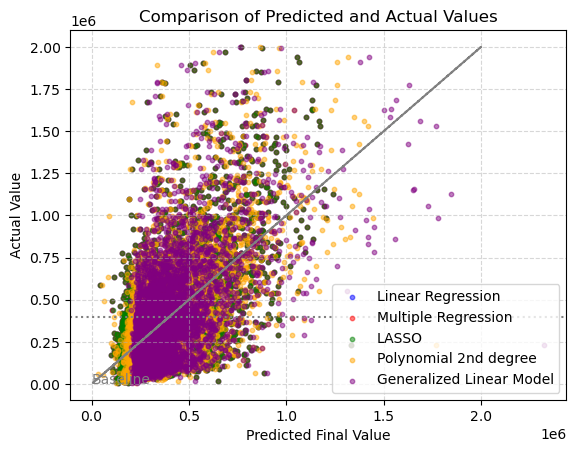

In [204]:

plt.scatter(plot_this.pred_OLS, plot_this.actual, label='Linear Regression', alpha=0.5, color='blue', s=10)
plt.scatter(plot_this.pred_MR, plot_this.actual, label='Multiple Regression', alpha=0.5, color='red', s=10)
plt.scatter(plot_this.pred_lars, plot_this.actual, label='LASSO', alpha=0.5, color='green', s=10)
plt.scatter(plot_this.pred_pr, plot_this.actual, label='Polynomial 2nd degree', alpha=0.5, color='orange', s=10)
plt.scatter(plot_this.pred_glm, plot_this.actual, label='Generalized Linear Model', alpha=0.5, color='purple', s=10)

plt.plot(plot_this.actual, plot_this.actual, label='_nolegend_', color='grey', linestyle='--')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81), color='grey')

plt.title("Comparison of Predicted and Actual Values")
plt.ylabel("Actual Value")
plt.xlabel("Predicted Final Value")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5) 

plt.show()


#### plotting the residuals

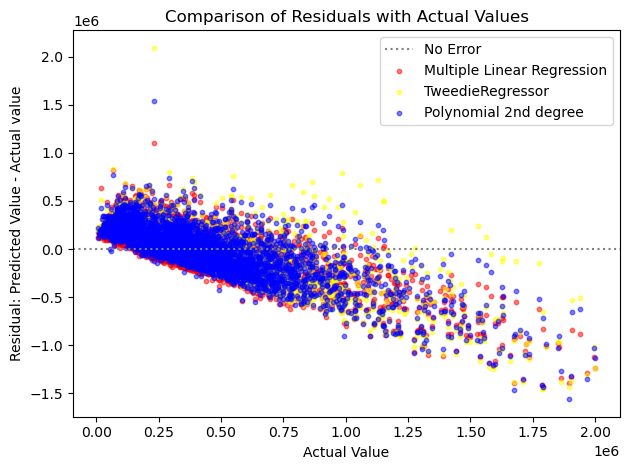

In [205]:
plt.axhline(0, ls=':', color='grey', label="No Error")

plt.scatter(plot_this.actual, plot_this.pred_MR - plot_this.actual, alpha=0.5, color="red", s=10, label="Multiple Linear Regression")
plt.scatter(plot_this.actual, plot_this.pred_glm - plot_this.actual, alpha=0.5, color="yellow", s=10, label="TweedieRegressor")
plt.scatter(plot_this.actual, plot_this.pred_pr - plot_this.actual, alpha=0.5, color="blue", s=10, label="Polynomial 2nd degree")

plt.legend()
plt.title("Comparison of Residuals with Actual Values")
plt.xlabel("Actual Value")
plt.ylabel("Residual: Predicted Value - Actual value")

plt.tight_layout()

plt.show()


#### histogram of actual and predicted values

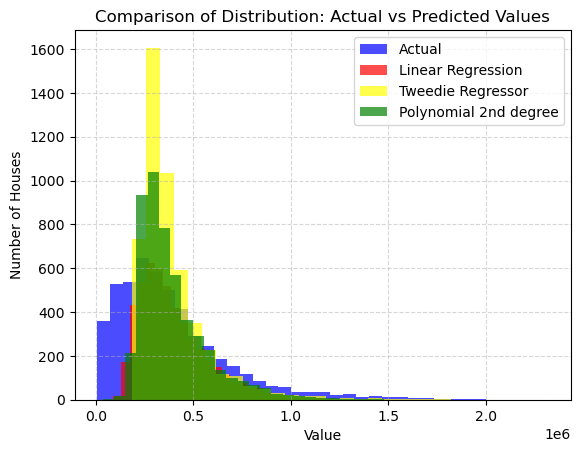

In [206]:
plt.hist(plot_this.actual, bins=30, color='blue', alpha=0.7, label="Actual")
plt.hist(plot_this.pred_MR, bins=30, color='red', alpha=0.7, label="Linear Regression")
plt.hist(plot_this.pred_glm, bins=30, color='yellow', alpha=0.7, label="Tweedie Regressor")
plt.hist(plot_this.pred_pr, bins=30, color='green', alpha=0.7, label="Polynomial 2nd degree")

plt.xlabel("Value")
plt.ylabel("Number of Houses")
plt.title("Comparison of Distribution: Actual vs Predicted Values")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5)  # Add gridlines

plt.show()
